<a href="https://colab.research.google.com/github/lyfhappie-coder/codemagaziny/blob/main/Copy_of_Untitled36.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1905792428.py:95: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.index = pd.date_range("2000-01-01", periods=n_steps, freq="H")


Generated data shape: (10000, 4)
Starting training on device: cpu


Epochs:   8%|▊         | 1/12 [01:06<12:11, 66.52s/it]

Epoch 01 | Train Loss: 0.888781 | Val Loss: 1.093290
  Saved best model to checkpoints/best_model.pth


Epochs:  17%|█▋        | 2/12 [02:14<11:11, 67.11s/it]

Epoch 02 | Train Loss: 0.761867 | Val Loss: 1.031608
  Saved best model to checkpoints/best_model.pth


Epochs:  25%|██▌       | 3/12 [03:20<10:01, 66.86s/it]

Epoch 03 | Train Loss: 0.538593 | Val Loss: 0.659803
  Saved best model to checkpoints/best_model.pth


Epochs:  33%|███▎      | 4/12 [04:35<09:20, 70.02s/it]

Epoch 04 | Train Loss: 0.399838 | Val Loss: 0.451684
  Saved best model to checkpoints/best_model.pth


Epochs:  42%|████▏     | 5/12 [05:41<08:01, 68.75s/it]

Epoch 05 | Train Loss: 0.293960 | Val Loss: 0.539590


Epochs:  50%|█████     | 6/12 [06:47<06:45, 67.66s/it]

Epoch 06 | Train Loss: 0.238224 | Val Loss: 0.281861
  Saved best model to checkpoints/best_model.pth


Epochs:  58%|█████▊    | 7/12 [07:53<05:35, 67.12s/it]

Epoch 07 | Train Loss: 0.168125 | Val Loss: 0.212899
  Saved best model to checkpoints/best_model.pth


Epochs:  67%|██████▋   | 8/12 [08:59<04:26, 66.70s/it]

Epoch 08 | Train Loss: 0.154539 | Val Loss: 0.204711
  Saved best model to checkpoints/best_model.pth


Epochs:  75%|███████▌  | 9/12 [10:04<03:19, 66.36s/it]

Epoch 09 | Train Loss: 0.149961 | Val Loss: 0.181309
  Saved best model to checkpoints/best_model.pth


Epochs:  83%|████████▎ | 10/12 [11:10<02:12, 66.00s/it]

Epoch 10 | Train Loss: 0.145430 | Val Loss: 0.171484
  Saved best model to checkpoints/best_model.pth


Epochs:  92%|█████████▏| 11/12 [12:14<01:05, 65.62s/it]

Epoch 11 | Train Loss: 0.142753 | Val Loss: 0.169744
  Saved best model to checkpoints/best_model.pth


Epochs: 100%|██████████| 12/12 [13:19<00:00, 66.63s/it]

Epoch 12 | Train Loss: 0.141429 | Val Loss: 0.168915
  Saved best model to checkpoints/best_model.pth
Loaded best model from epoch 12


Test loss (scaled MSE): 0.37185882005735216
Test Metrics: {'RMSE': 7.405376800491079, 'MAE': 5.8515054440870715, 'MAPE(%)': np.float64(7.045440188341429), 'DirectionalAcc': 0.4954128440366973}


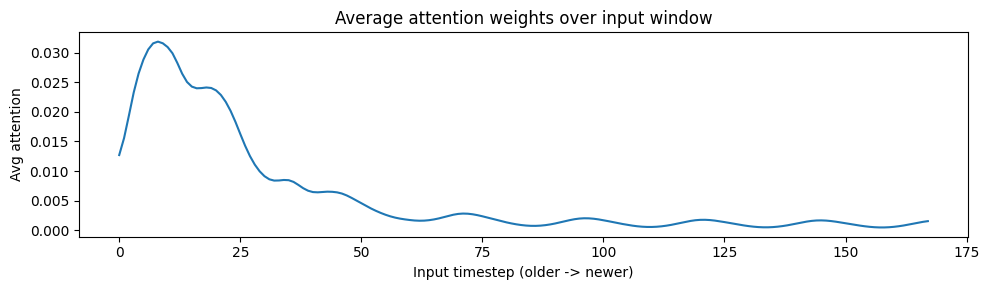

Saved avg_attention.png


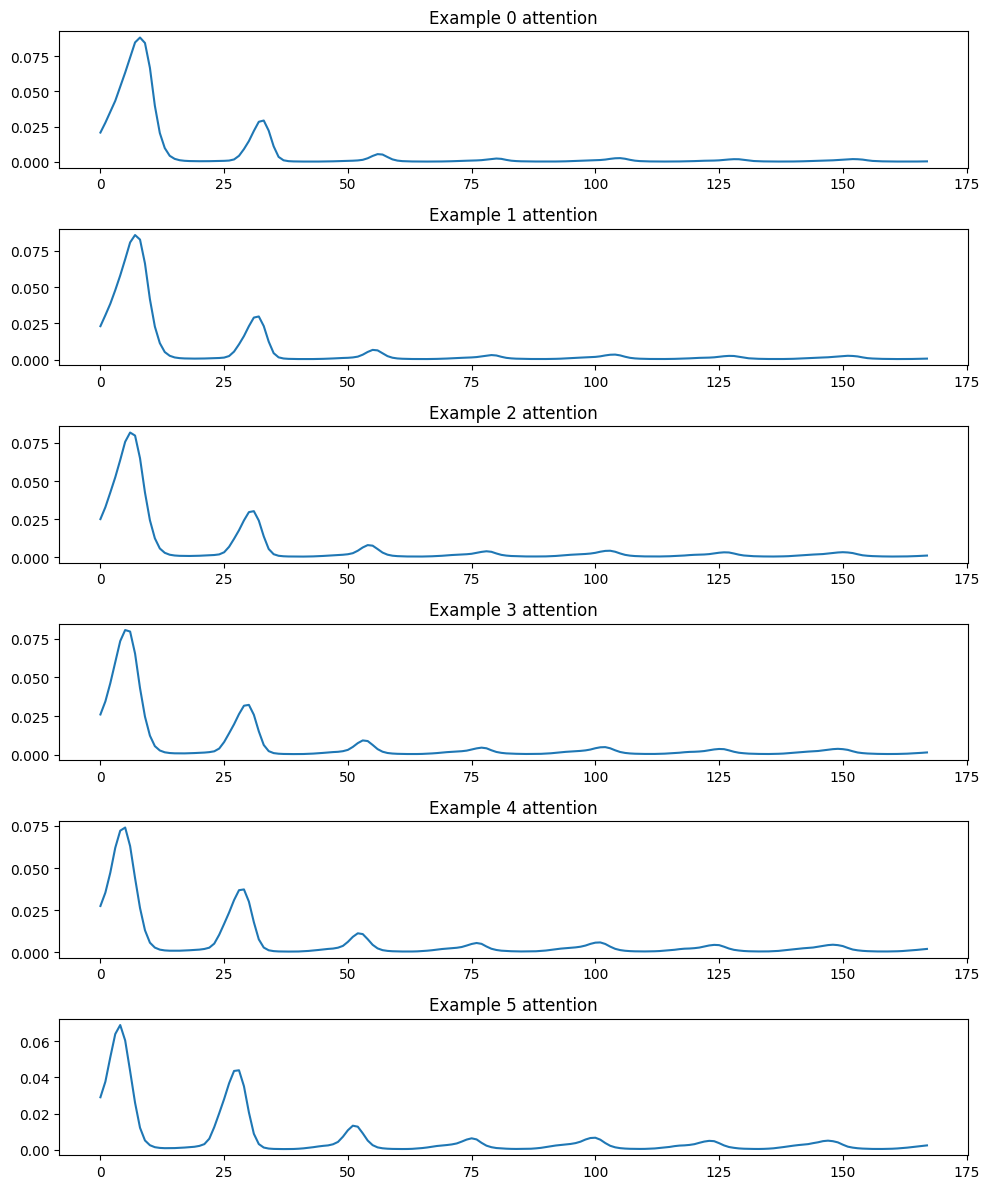

Saved sample_attentions.png
Saved preds.csv and y_true.csv


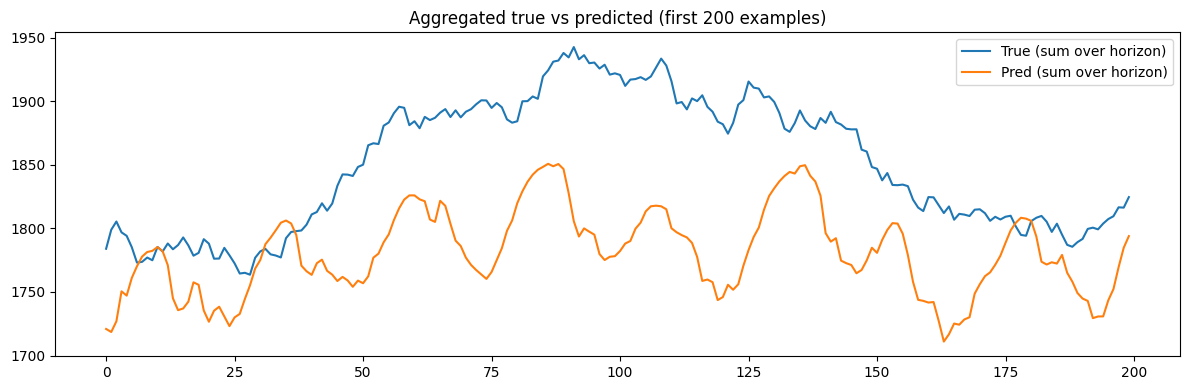

Saved agg_true_pred.png
Done.


In [ ]:
# Colab-ready: forecast_lstm_attention_colab.py
"""
Advanced Time Series Forecasting: LSTM + Attention (PyTorch)
Colab-ready single-file script (fixed inverse-scaling + safe attention stacking)

Run in Google Colab (make sure torch, pandas, scikit-learn, matplotlib, tqdm are installed).
"""

import os
import math
import random
from typing import Dict, Any
import numpy as np
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---------------------------
# Config / Hyperparameters
# ---------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRINT_EVERY = 1

# Data params
N_SAMPLES = 10000      # total time steps
HORIZON = 24           # prediction horizon (multi-step)
INPUT_WINDOW = 168     # lookback (e.g., one week hourly -> 168)
BATCH_SIZE = 128

# Model params
HIDDEN_SIZE = 128
NUM_LAYERS = 2
DROPOUT = 0.1
DENSE_SIZE = 64
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 12  # reduce for quick Colab runs; increase as needed

CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


# ---------------------------
# Synthetic Data Generator
# ---------------------------
def generate_multivariate_series(n_steps: int, seed: int = SEED) -> pd.DataFrame:
    """
    Programmatically generate a multivariate time series DataFrame with:
    - global trend
    - multiple seasonalities (daily, weekly, yearly-ish)
    - exogenous features correlated with target
    - heteroscedastic noise
    """
    rng = np.random.RandomState(seed)
    t = np.arange(n_steps)

    # Trend (smooth polynomial)
    trend = 0.0005 * (t ** 1.2)

    # Seasonalities
    daily = 10 * np.sin(2 * np.pi * t / 24)
    weekly = 5 * np.sin(2 * np.pi * t / (24 * 7))
    long = 3 * np.sin(2 * np.pi * t / (24 * 365 + 30))  # long season

    # Exogenous covariates (some correlated with target)
    exog1 = 0.8 * daily + 0.2 * rng.normal(scale=2, size=n_steps)   # strongly correlated
    exog2 = 2.0 * np.cos(2 * np.pi * t / 12) + rng.normal(scale=1.5, size=n_steps)
    exog3 = rng.normal(scale=3.0, size=n_steps)  # noisy unrelated

    base_target = 50 + trend + daily + weekly * 0.6 + long * 0.4
    noise_scale = 1.0 + 0.05 * np.abs(base_target)  # heteroscedastic noise
    noise = rng.normal(scale=noise_scale, size=n_steps)

    target = base_target + 0.5 * exog1 + 0.2 * exog2 + noise

    df = pd.DataFrame({
        "target": target,
        "exog1": exog1,
        "exog2": exog2,
        "exog3": exog3
    })
    df.index = pd.date_range("2000-01-01", periods=n_steps, freq="H")
    return df


# ---------------------------
# Sliding-window dataset
# ---------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, data: np.ndarray, input_len: int, out_len: int):
        """
        data: numpy array shape (T, n_features)
        """
        self.data = data
        self.input_len = input_len
        self.out_len = out_len
        max_start = len(data) - input_len - out_len + 1
        if max_start <= 0:
            raise ValueError(f"Data too short for input_len={input_len} and out_len={out_len}.")
        self.indices = np.arange(max_start)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        x = self.data[i: i + self.input_len]          # (input_len, n_features)
        y = self.data[i + self.input_len: i + self.input_len + self.out_len, 0]  # target only (first col)
        return torch.from_numpy(x).float(), torch.from_numpy(y).float()


# ---------------------------
# LSTM + Attention Model
# ---------------------------
class AdditiveAttention(nn.Module):
    """
    Simple additive attention (Bahdanau-style) over encoder hidden states.
    Returns context vector and attention weights.
    """
    def __init__(self, enc_hidden_size: int, dec_hidden_size: int):
        super().__init__()
        self.W_enc = nn.Linear(enc_hidden_size, enc_hidden_size, bias=False)
        self.W_dec = nn.Linear(dec_hidden_size, enc_hidden_size, bias=False)
        self.v = nn.Linear(enc_hidden_size, 1, bias=False)

    def forward(self, encoder_outputs: torch.Tensor, decoder_state: torch.Tensor):
        # encoder_outputs: (batch, seq_len, enc_hidden)
        # decoder_state: (batch, dec_hidden)
        enc_t = self.W_enc(encoder_outputs)                         # (batch, seq_len, enc_hidden)
        dec_t = self.W_dec(decoder_state).unsqueeze(1)              # (batch, 1, enc_hidden)
        score = torch.tanh(enc_t + dec_t)                           # (batch, seq_len, enc_hidden)
        e = self.v(score).squeeze(-1)                               # (batch, seq_len)
        weights = torch.softmax(e, dim=1)                           # (batch, seq_len)
        context = torch.bmm(weights.unsqueeze(1), encoder_outputs).squeeze(1)  # (batch, enc_hidden)
        return context, weights


class LSTMWithAttention(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, horizon: int, dropout: float = 0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.horizon = horizon

        self.encoder = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        self.attention = AdditiveAttention(enc_hidden_size=hidden_size, dec_hidden_size=hidden_size)
        self.fc1 = nn.Linear(hidden_size, DENSE_SIZE)
        self.fc2 = nn.Linear(DENSE_SIZE, horizon)  # predict horizon steps of target directly
        self.dropout = nn.Dropout(dropout)
        self.act = nn.ReLU()

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        enc_out, (h_n, c_n) = self.encoder(x)  # enc_out: (batch, seq_len, hidden)
        last_hidden = h_n[-1]  # (batch, hidden)
        context, attn_weights = self.attention(enc_out, last_hidden)  # context: (batch, hidden)
        out = self.act(self.fc1(context))
        out = self.dropout(out)
        out = self.fc2(out)  # (batch, horizon)
        return out, attn_weights


# ---------------------------
# Utility Functions
# ---------------------------
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    n_samples = 0
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        optimizer.zero_grad()
        preds, _ = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        bs = xb.size(0)
        total_loss += loss.item() * bs
        n_samples += bs
    return total_loss / (n_samples + 1e-12)


def evaluate(model, loader, criterion):
    model.eval()
    losses = []
    preds_list = []
    y_list = []
    attn_list = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            preds, attn = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item() * xb.size(0))
            preds_list.append(preds.cpu().numpy())
            y_list.append(yb.cpu().numpy())
            # attn: (batch, seq_len)
            attn_list.append(attn.cpu().numpy())
    preds = np.vstack(preds_list) if len(preds_list) > 0 else np.empty((0, HORIZON))
    y = np.vstack(y_list) if len(y_list) > 0 else np.empty((0, HORIZON))
    attn = np.vstack(attn_list) if len(attn_list) > 0 else np.empty((0, INPUT_WINDOW))
    total = np.sum(losses) if len(losses) > 0 else 0.0
    avg_loss = total / (len(loader.dataset) + 1e-12)
    return avg_loss, preds, y, attn


def directional_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Fraction of times the direction of aggregate (sum over horizon) is predicted correctly.
    """
    if len(y_true) < 2 or len(y_pred) < 2:
        return float("nan")
    true_sum = np.sum(y_true, axis=1)
    pred_sum = np.sum(y_pred, axis=1)
    true_dir = np.sign(true_sum[1:] - true_sum[:-1])
    pred_dir = np.sign(pred_sum[1:] - pred_sum[:-1])
    min_len = min(len(true_dir), len(pred_dir))
    if min_len == 0:
        return float("nan")
    return float(np.mean(true_dir[:min_len] == pred_dir[:min_len]))


def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, Any]:
    if y_true.size == 0 or y_pred.size == 0:
        return {"RMSE": float("nan"), "MAE": float("nan"), "MAPE(%)": float("nan"), "DirectionalAcc": float("nan")}
    rmse = math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    # robust MAPE (avoid division by zero)
    denom = np.clip(np.abs(y_true), 1e-6, None)
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100.0
    da = directional_accuracy(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "MAPE(%)": mape, "DirectionalAcc": da}


# ---------------------------
# Main: prepare data, train, evaluate
# ---------------------------
def main():
    # 1) Data generation
    df = generate_multivariate_series(N_SAMPLES, seed=SEED)
    print("Generated data shape:", df.shape)

    # 2) Train/val/test split (temporal)
    train_ratio = 0.7
    val_ratio = 0.15
    test_ratio = 0.15
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

    n = len(df)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)

    df_train = df.iloc[:train_end]
    df_val = df.iloc[train_end:val_end]
    df_test = df.iloc[val_end:]

    # 3) Scaling: Fit on train only
    scaler = StandardScaler()
    scaler.fit(df_train.values)  # fits per-feature
    train_scaled = scaler.transform(df_train.values)
    val_scaled = scaler.transform(df_val.values)
    test_scaled = scaler.transform(df_test.values)

    # 4) Datasets + loaders (pin_memory if using GPU)
    pin_mem = True if torch.cuda.is_available() else False
    train_ds = TimeSeriesDataset(train_scaled, INPUT_WINDOW, HORIZON)
    val_ds = TimeSeriesDataset(val_scaled, INPUT_WINDOW, HORIZON)
    test_ds = TimeSeriesDataset(test_scaled, INPUT_WINDOW, HORIZON)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, pin_memory=pin_mem, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=pin_mem, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=pin_mem, num_workers=2)

    # 5) Model
    input_size = df.shape[1]  # number of features
    model = LSTMWithAttention(input_size=input_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, horizon=HORIZON, dropout=DROPOUT)
    model = model.to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.MSELoss()

    # 6) Training loop with validation & checkpointing
    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": []}

    print("Starting training on device:", DEVICE)
    for epoch in trange(1, EPOCHS + 1, desc="Epochs"):
        train_loss = train_epoch(model, train_loader, optimizer, criterion)
        val_loss, _, _, _ = evaluate(model, val_loader, criterion)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        if epoch % PRINT_EVERY == 0:
            print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        # Checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            ckpt_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
            torch.save({"epoch": epoch, "model_state": model.state_dict(), "scaler": scaler}, ckpt_path)
            print(f"  Saved best model to {ckpt_path}")

    # 7) Load best model & test evaluation
    ckpt_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
    if os.path.exists(ckpt_path):
        # Changed weights_only=True to False to allow loading of scaler from sklearn
        ckpt = torch.load(ckpt_path, map_location=DEVICE, weights_only=False)
        model.load_state_dict(ckpt["model_state"])
        print(f"Loaded best model from epoch {ckpt.get('epoch', 'unknown')}")
    else:
        print("No checkpoint found; evaluating current model.")

    test_loss, preds_scaled, y_scaled, attn_weights = evaluate(model, test_loader, criterion)
    print("Test loss (scaled MSE):", test_loss)

    # 8) Inverse transform predictions and ground truth for metrics (target was column 0)
    def unscale_target(arr_scaled_target, base_scaler, original_feature_index=0):
        """
        arr_scaled_target: (n_examples, horizon)
        base_scaler: fitted StandardScaler
        Produces unscaled target array same shape.
        """
        if arr_scaled_target.size == 0:
            return np.empty_like(arr_scaled_target)
        n_examples, horizon = arr_scaled_target.shape
        reshaped = arr_scaled_target.reshape(-1)  # (n_examples*horizon,)
        tmp = np.zeros((reshaped.shape[0], base_scaler.mean_.shape[0]), dtype=float)
        tmp[:, original_feature_index] = reshaped
        inv = base_scaler.inverse_transform(tmp)[:, original_feature_index]
        return inv.reshape(n_examples, horizon)

    preds = unscale_target(preds_scaled, scaler)
    y_true = unscale_target(y_scaled, scaler)

    metrics = compute_metrics(y_true, preds)
    print("Test Metrics:", metrics)

    # 9) Attention analysis
    # attn_weights shape: (n_examples, seq_len) or empty
    if attn_weights.size == 0:
        print("No attention weights collected (empty). Skipping attention plots.")
    else:
        mean_attn = attn_weights.mean(axis=0)  # seq_len
        plt.figure(figsize=(10, 3))
        plt.plot(mean_attn)
        plt.title("Average attention weights over input window")
        plt.xlabel("Input timestep (older -> newer)")
        plt.ylabel("Avg attention")
        plt.tight_layout()
        plt.savefig("avg_attention.png")
        plt.show()
        print("Saved avg_attention.png")

        # Visualize attention for a few examples
        NUM_EXAMPLES_TO_PLOT = min(6, attn_weights.shape[0])
        fig, axs = plt.subplots(NUM_EXAMPLES_TO_PLOT, 1, figsize=(10, 2 * NUM_EXAMPLES_TO_PLOT))
        if NUM_EXAMPLES_TO_PLOT == 1:
            axs = [axs]
        for i in range(NUM_EXAMPLES_TO_PLOT):
            ax = axs[i]
            ax.plot(attn_weights[i])
            ax.set_title(f"Example {i} attention")
        plt.tight_layout()
        plt.savefig("sample_attentions.png")
        plt.show()
        print("Saved sample_attentions.png")

    # 10) Save predictions for external analysis
    preds_df = pd.DataFrame(preds)
    y_df = pd.DataFrame(y_true)
    preds_df.to_csv("preds.csv", index=False)
    y_df.to_csv("y_true.csv", index=False)
    print("Saved preds.csv and y_true.csv")

    # 11) Plot actual vs predicted aggregated (first 200 points)
    if preds.shape[0] > 0 and y_true.shape[0] > 0:
        plt.figure(figsize=(12, 4))
        agg_true = y_true[:200].sum(axis=1)
        agg_pred = preds[:200].sum(axis=1)
        plt.plot(agg_true, label="True (sum over horizon)")
        plt.plot(agg_pred, label="Pred (sum over horizon)")
        plt.legend()
        plt.title("Aggregated true vs predicted (first 200 examples)")
        plt.tight_layout()
        plt.savefig("agg_true_pred.png")
        plt.show()
        print("Saved agg_true_pred.png")
    else:
        print("No predictions available for aggregate plot.")

    print("Done.")


if __name__ == "__main__":
    main()

In [ ]:
if __name__ == "__main__":
    main()